# Heart Disease Prediction using Artificial Neural Network

This notebook implements a neural network from scratch for heart disease prediction, following these tasks:
1. Model Implementation
2. Model Evaluation
3. Model Performance Optimization

## Dataset Description
The Heart Disease Dataset contains 303 samples with 13 features:
- age
- sex
- chest pain type
- resting blood pressure
- cholesterol levels
- fasting blood sugar
- resting electrocardiographic results
- maximum heart rate achieved
- exercise induced angina
- ST depression induced by exercise relative to rest
- slope of the peak exercise ST segment
- number of major vessels colored by fluoroscopy
- athalassemia type

Target: Binary classification (0 – no risk, 1 – at risk)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

## Task 1: Model Implementation

### Neural Network Architecture
- Input Layer: 13 neurons (one for each feature)
- Hidden Layer: 8 neurons with sigmoid activation
- Output Layer: 1 neuron with sigmoid activation (binary classification)

### Mathematical Foundation

#### Forward Propagation
1. Hidden Layer:
   - Z₁ = X·W₁ + b₁ (linear transformation)
   - A₁ = sigmoid(Z₁) (activation)

2. Output Layer:
   - Z₂ = A₁·W₂ + b₂
   - A₂ = sigmoid(Z₂)

#### Backward Propagation
1. Output Layer Gradients:
   - dZ₂ = A₂ - y
   - dW₂ = (1/m) * A₁ᵀ·dZ₂
   - db₂ = (1/m) * Σ(dZ₂)

2. Hidden Layer Gradients:
   - dZ₁ = W₂·dZ₂ᵀ ⊙ sigmoid_derivative(A₁)
   - dW₁ = (1/m) * Xᵀ·dZ₁
   - db₁ = (1/m) * Σ(dZ₁)

#### Loss Function
Binary Cross-Entropy:
L = -(1/m) * Σ(y·log(ŷ) + (1-y)·log(1-ŷ))

In [3]:
# Neural Network Implementation
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # Initialize weights using uniform distribution between -1 and 1
        self.W1 = np.random.uniform(-1, 1, (input_size, hidden_size))
        self.W2 = np.random.uniform(-1, 1, (hidden_size, output_size))
        
        # Initialize biases to 0
        self.b1 = np.zeros((1, hidden_size))
        self.b2 = np.zeros((1, output_size))
        
        self.learning_rate = learning_rate
        self.loss_history = []
        self.accuracy_history = []
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def sigmoid_derivative(self, A):
        return A * (1 - A)
    
    def forward_propagation(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2
    
    def backward_propagation(self, X, y):
        m = X.shape[0]
        
        dZ2 = self.A2 - y
        dW2 = (1/m) * np.dot(self.A1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        
        dZ1 = np.dot(dZ2, self.W2.T) * self.sigmoid_derivative(self.A1)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        
        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    def update_parameters(self, gradients):
        self.W1 -= self.learning_rate * gradients["dW1"]
        self.b1 -= self.learning_rate * gradients["db1"]
        self.W2 -= self.learning_rate * gradients["dW2"]
        self.b2 -= self.learning_rate * gradients["db2"]
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -(1/m) * np.sum(y_true * np.log(y_pred + 1e-15) + 
                              (1 - y_true) * np.log(1 - y_pred + 1e-15))
        return loss
    
    def get_accuracy(self, X, y):
        predictions = (self.forward_propagation(X) >= 0.5).astype(int)
        return np.mean(predictions == y)
    
    def train(self, X, y, epochs, batch_size):
        for epoch in range(epochs):
            # Create mini-batches
            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                
                # Forward propagation
                y_pred = self.forward_propagation(X_batch)
                
                # Backward propagation
                gradients = self.backward_propagation(X_batch, y_batch)
                
                # Update parameters
                self.update_parameters(gradients)
            
            # Compute epoch metrics
            y_pred_all = self.forward_propagation(X)
            epoch_loss = self.compute_loss(y, y_pred_all)
            epoch_accuracy = self.get_accuracy(X, y)
            
            self.loss_history.append(epoch_loss)
            self.accuracy_history.append(epoch_accuracy)
            
            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch + 1}/{epochs}")
                print(f"Loss: {epoch_loss:.4f}")
                print(f"Accuracy: {epoch_accuracy:.4f}\n")

In [4]:
# Load and preprocess data
data = pd.read_csv('heart-disease.csv')
X = data.drop('target', axis=1).values
y = data['target'].values.reshape(-1, 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train model with specified parameters
model = NeuralNetwork(
    input_size=13,
    hidden_size=8,
    output_size=1,
    learning_rate=0.01
)

# Train with specified parameters
model.train(
    X=X_train,
    y=y_train,
    epochs=500,
    batch_size=128
)

Epoch 50/500
Loss: 0.6559
Accuracy: 0.6736

Epoch 100/500
Loss: 0.6266
Accuracy: 0.7025

Epoch 150/500
Loss: 0.6012
Accuracy: 0.7314

Epoch 200/500
Loss: 0.5791
Accuracy: 0.7355

Epoch 250/500
Loss: 0.5597
Accuracy: 0.7727

Epoch 300/500
Loss: 0.5425
Accuracy: 0.7851

Epoch 350/500
Loss: 0.5272
Accuracy: 0.7851

Epoch 400/500
Loss: 0.5135
Accuracy: 0.7934

Epoch 450/500
Loss: 0.5013
Accuracy: 0.7893

Epoch 500/500
Loss: 0.4903
Accuracy: 0.7893



## Task 2: Model Evaluation

### Evaluation Strategy
1. Split data into training (80%) and test (20%) sets
2. Use multiple evaluation metrics:
   - Binary Cross-Entropy Loss
   - Classification Accuracy
   - Precision, Recall, F1-Score
   - ROC Curve and AUC
   - Confusion Matrix
3. Analyze training stability through multiple runs

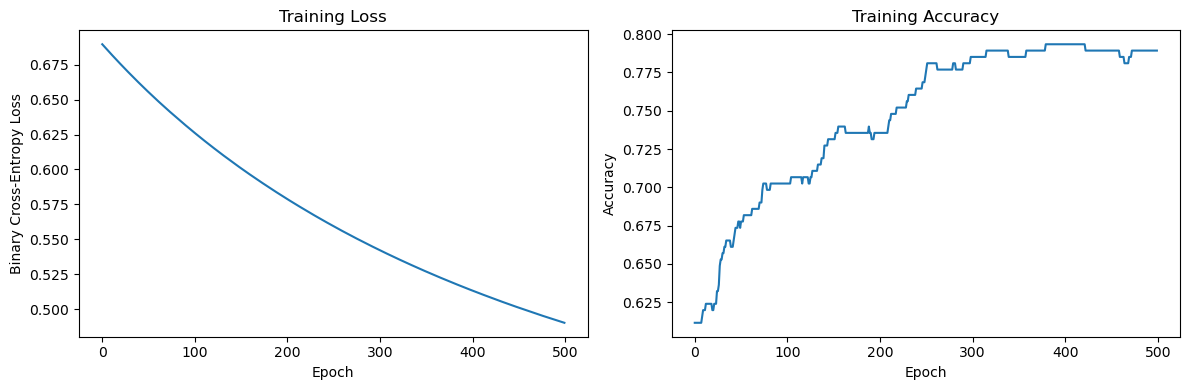

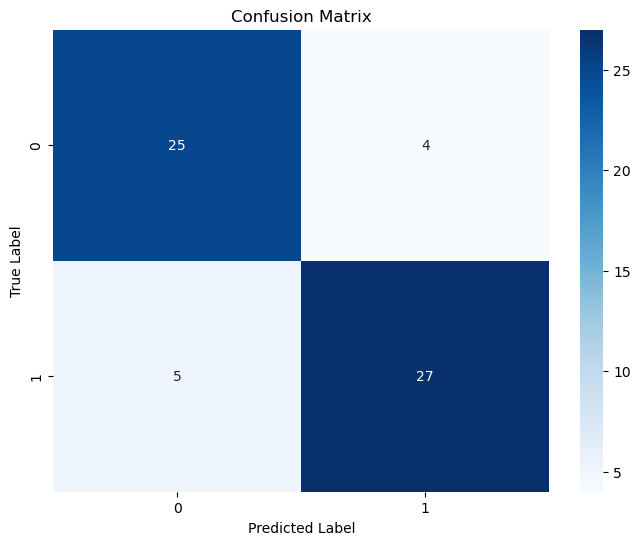

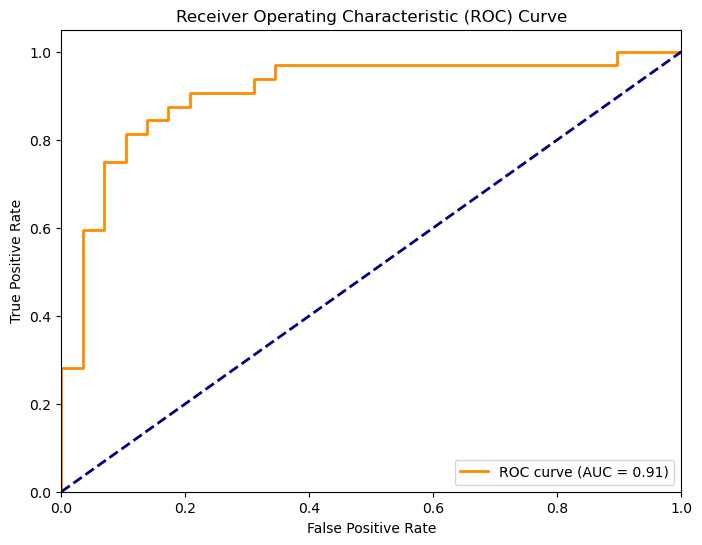


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



In [5]:
def plot_training_metrics(model):
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model.loss_history)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-Entropy Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(model.accuracy_history)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot training metrics
plot_training_metrics(model)

# Get predictions
y_pred_proba = model.forward_propagation(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC curve
plot_roc_curve(y_test, y_pred_proba)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

## Task 3: Model Performance Optimization

### Optimization Strategies
1. Experiment with different activation functions:
   - Sigmoid (baseline)
   - ReLU
   - Tanh

2. Vary hidden layer neurons:
   - 4 neurons
   - 8 neurons (baseline)
   - 16 neurons
   - 32 neurons

3. Test different learning rates:
   - 0.001
   - 0.01 (baseline)
   - 0.1

Epoch 50/500
Loss: 0.8403
Accuracy: 0.5537

Epoch 100/500
Loss: 0.7300
Accuracy: 0.5455

Epoch 150/500
Loss: 0.6775
Accuracy: 0.5702

Epoch 200/500
Loss: 0.6460
Accuracy: 0.6322

Epoch 250/500
Loss: 0.6227
Accuracy: 0.6694

Epoch 300/500
Loss: 0.6013
Accuracy: 0.6860

Epoch 350/500
Loss: 0.5829
Accuracy: 0.7066

Epoch 400/500
Loss: 0.5671
Accuracy: 0.7314

Epoch 450/500
Loss: 0.5527
Accuracy: 0.7479

Epoch 500/500
Loss: 0.5408
Accuracy: 0.7645


Activation: sigmoid
Test Accuracy: 0.7541
Epoch 50/500
Loss: 0.7157
Accuracy: 0.6612

Epoch 100/500
Loss: 0.5553
Accuracy: 0.7521

Epoch 150/500
Loss: 0.4912
Accuracy: 0.7893

Epoch 200/500
Loss: 0.4554
Accuracy: 0.7975

Epoch 250/500
Loss: 0.4267
Accuracy: 0.8017

Epoch 300/500
Loss: 0.4079
Accuracy: 0.8017

Epoch 350/500
Loss: 0.3973
Accuracy: 0.8058

Epoch 400/500
Loss: 0.3823
Accuracy: 0.8140

Epoch 450/500
Loss: 0.3739
Accuracy: 0.8306

Epoch 500/500
Loss: 0.3702
Accuracy: 0.8388


Activation: relu
Test Accuracy: 0.8361
Epoch 50/500
Loss: 

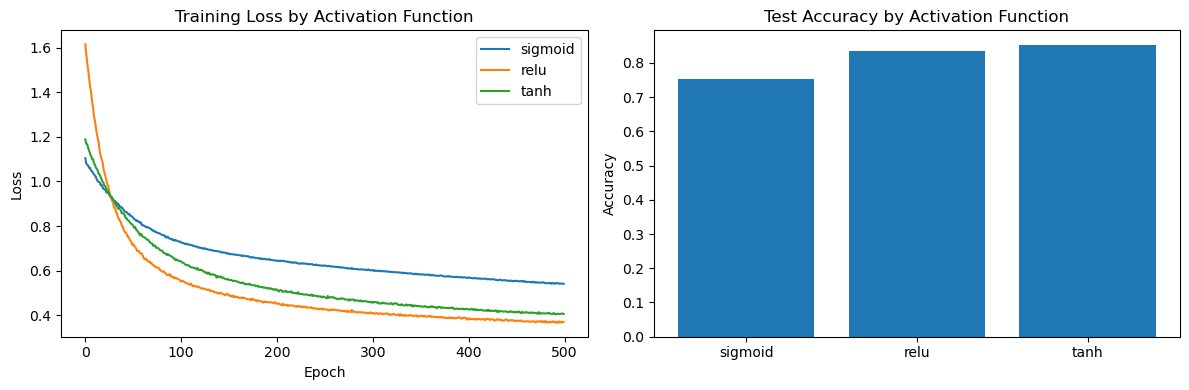

In [6]:
from task3_optimization import OptimizedNeuralNetwork

def experiment_activation_functions():
    activations = ['sigmoid', 'relu', 'tanh']
    results = []
    
    for activation in activations:
        model = OptimizedNeuralNetwork(
            input_size=13,
            hidden_size=8,
            output_size=1,
            learning_rate=0.01,
            activation=activation
        )
        
        model.train(X_train, y_train, epochs=500, batch_size=128)
        test_acc = model.get_accuracy(X_test, y_test)
        
        results.append({
            'activation': activation,
            'test_acc': test_acc,
            'loss_history': model.loss_history
        })
        
        print(f"\nActivation: {activation}")
        print(f"Test Accuracy: {test_acc:.4f}")
    
    return results

# Run experiments
activation_results = experiment_activation_functions()

# Plot results
plt.figure(figsize=(12, 4))

# Loss curves
plt.subplot(1, 2, 1)
for result in activation_results:
    plt.plot(result['loss_history'], label=result['activation'])
plt.title('Training Loss by Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Test accuracies
plt.subplot(1, 2, 2)
activations = [r['activation'] for r in activation_results]
accuracies = [r['test_acc'] for r in activation_results]
plt.bar(activations, accuracies)
plt.title('Test Accuracy by Activation Function')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()